In [1]:
import pandas as pd
import numpy as np
from IPython.display import Math #para escrever equações 
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error, mean_squared_error
import statsmodels.api as sm
import seaborn as sns

import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

In [3]:
from random import randint
from xmlrpc.client import Boolean
from tqdm import tqdm
import pandas as pd
import numpy as np
import quantecon as qe

import logging
log = logging.getLogger(__name__)
# logging.basicConfig(level=logging.DEBUG) 


In [4]:
RANDOM_SIZE   = 1000000
RANDOM_SIZE   = 200
QTD_BINS      = 3
TEST_SIZE     = 0.05
RANDOM_STATE  = 2022
PREDITOR                 = ['vegetable-oil_price', 'vegetable-oil_production', 'vegetable-oil_exports']
PREDITOR_DIRECTIONS      = ['vegetable-oil_price', 'vegetable-oil_production', 'vegetable-oil_exports']

- https://raw.githubusercontent.com/fkfouri/vegetable_oil_mkt/master/dataset/__by_month_commodity_types.csv
- https://raw.githubusercontent.com/fkfouri/vegetable_oil_mkt/master/dataset/__by_month_vegetable_oil.csv
- https://raw.githubusercontent.com/fkfouri/vegetable_oil_mkt/master/dataset/__by_month_full.csv

# Mercado de Oleo

## Dataset Completo
- USDA por comodity
- USDA Agrupado por Oleo Vegetal
- OECD Agrupado
- FAO Index Price


In [5]:
def get_dataset():
    df = pd.read_csv('https://raw.githubusercontent.com/fkfouri/vegetable_oil_mkt/master/dataset/__by_month_full.csv')
    print(df.shape)
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values(by=['date'], ascending=[True], inplace=True)
    df.set_index(['date'], inplace=True)
    return df

%time df_full = get_dataset()
df_full.head()

(266, 139)
CPU times: total: 46.9 ms
Wall time: 410 ms


,reference,coconut_beginning-stocks,coconut_crush,coconut_domestic-consumption,coconut_ending-stocks,coconut_exports,coconut_feed-waste-dom-cons,coconut_food-use-dom-cons,coconut_imports,coconut_industrial-dom-cons,...,vegetable-oil_total-supply,vegetable-oil_oecd_consumption,vegetable-oil_oecd_ending-stocks,vegetable-oil_oecd_exports,vegetable-oil_oecd_food,vegetable-oil_oecd_food-fat-availability,vegetable-oil_oecd_human-consumption-per-capita,vegetable-oil_oecd_imports,vegetable-oil_oecd_other-use,vegetable-oil_oecd_production
date,,,,,,,,,,,,,,,,,,,,,
2000-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,7273.770,844.920,2541.320,6179.990,2.240,1.020,2490.870,1088.770,7469.760
2000-02-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,7298.970,849.930,2562.660,6190.320,2.240,1.020,2504.980,1098.620,7494.420
2000-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,7324.160,854.950,2584.010,6200.660,2.240,1.020,2519.100,1108.460,7519.090
2000-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,7349.360,859.960,2605.360,6211.000,2.240,1.030,2533.210,1118.310,7543.750
2000-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,7374.550,864.970,2626.710,6221.340,2.250,1.030,2547.320,1128.150,7568.420


In [6]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 266 entries, 2000-01-31 to 2022-02-28
Columns: 138 entries, reference to vegetable-oil_oecd_production
dtypes: float64(137), object(1)
memory usage: 288.9+ KB


In [7]:
df_full.dtypes

reference                                           object
coconut_beginning-stocks                           float64
coconut_crush                                      float64
coconut_domestic-consumption                       float64
coconut_ending-stocks                              float64
                                                    ...   
vegetable-oil_oecd_food-fat-availability           float64
vegetable-oil_oecd_human-consumption-per-capita    float64
vegetable-oil_oecd_imports                         float64
vegetable-oil_oecd_other-use                       float64
vegetable-oil_oecd_production                      float64
Length: 138, dtype: object

In [8]:
#Identificacao de colunas/atributos
features = [x for x in df_full.columns if ('exports' in x or 'production' in x or 'price' in x) and not ('olive' in x or 'cottonseed' in x) ]
prices   = [x for x in df_full.columns if 'price' in x and 'groundnut' not in x  ]

print(f'features: {len(features)} | {features}')
print("==" * 30)
print(f'prices: {len(prices)} | {prices}')

features: 26 | ['coconut_exports', 'coconut_price', 'coconut_production', 'palm-kernel_exports', 'palm-kernel_price', 'palm-kernel_production', 'palm_exports', 'palm_price', 'palm_production', 'peanut_exports', 'peanut_price', 'peanut_production', 'rapeseed_exports', 'rapeseed_price', 'rapeseed_production', 'soybean_exports', 'soybean_price', 'soybean_production', 'sunflower_exports', 'sunflower_price', 'sunflower_production', 'vegetable-oil_exports', 'vegetable-oil_price', 'vegetable-oil_production', 'vegetable-oil_oecd_exports', 'vegetable-oil_oecd_production']
prices: 8 | ['coconut_price', 'palm-kernel_price', 'palm_price', 'peanut_price', 'rapeseed_price', 'soybean_price', 'sunflower_price', 'vegetable-oil_price']


In [9]:
#REMOÇÃO DE CAMPOS NAN
df = df_full[features].copy()
print(df.shape)
df = df[df['sunflower_production'].notnull()]
df = df[df['sunflower_price'].notnull()]
print(df.shape)
df

(266, 26)
(234, 26)


,coconut_exports,coconut_price,coconut_production,palm-kernel_exports,palm-kernel_price,palm-kernel_production,palm_exports,palm_price,palm_production,peanut_exports,...,soybean_price,soybean_production,sunflower_exports,sunflower_price,sunflower_production,vegetable-oil_exports,vegetable-oil_price,vegetable-oil_production,vegetable-oil_oecd_exports,vegetable-oil_oecd_production
date,,,,,,,,,,,,,,,,,,,,,
2002-02-28,148.440,376.000,255.940,130.470,356.000,264.710,1527.920,352.980,2146.310,17.030,...,364.920,3204.320,166.180,578.000,620.920,3312.180,47.786,8559.630,2986.310,7954.130
2002-03-31,148.040,366.000,255.830,130.830,353.240,266.520,1543.880,359.000,2162.830,16.580,...,359.210,3222.400,168.850,557.000,625.580,3339.800,47.622,8591.720,3014.280,7983.170
2002-04-30,147.640,411.000,255.720,131.190,405.000,268.330,1559.830,360.070,2179.360,16.140,...,370.860,3240.470,171.530,552.000,630.250,3367.440,48.969,8623.810,3042.260,8012.210
2002-05-31,147.240,420.000,255.610,131.560,418.300,270.150,1575.790,384.910,2195.890,15.690,...,399.890,3258.550,174.200,574.000,634.920,3395.080,51.641,8655.950,3070.240,8041.250
2002-06-30,146.830,446.000,255.500,131.920,439.000,271.960,1591.750,426.130,2212.420,15.250,...,456.810,3276.620,176.880,595.000,639.580,3422.710,55.804,8688.040,3098.220,8070.290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-31,157.080,1493.640,290.610,276.780,1341.140,716.470,4092.220,1141.820,6229.440,35.640,...,1433.940,6354.170,988.220,1355.691,1703.690,7821.270,165.862,18894.320,7325.470,18174.560
2021-09-30,158.080,1485.000,291.080,278.380,1427.270,718.600,4103.190,1181.380,6246.960,35.020,...,1398.750,6350.750,994.670,1309.519,1717.600,7837.790,168.571,18923.870,7328.510,18207.820
2021-10-31,159.080,1922.860,291.560,279.970,1818.330,720.740,4114.150,1310.250,6264.470,34.400,...,1483.520,6347.330,1001.110,1420.528,1731.510,7854.300,184.837,18953.420,7331.560,18241.070


In [10]:
df.describe()

,coconut_exports,coconut_price,coconut_production,palm-kernel_exports,palm-kernel_price,palm-kernel_production,palm_exports,palm_price,palm_production,peanut_exports,...,soybean_price,soybean_production,sunflower_exports,sunflower_price,sunflower_production,vegetable-oil_exports,vegetable-oil_price,vegetable-oil_production,vegetable-oil_oecd_exports,vegetable-oil_oecd_production
count,234.000,234.000,234.000,234.000,234.000,234.000,234.000,234.000,234.000,234.000,...,234.000,234.000,234.000,234.000,234.000,234.000,234.000,234.000,234.000,234.000
mean,154.793,1037.208,277.760,233.840,956.092,523.365,3226.635,763.075,4406.418,19.901,...,882.535,4857.446,563.021,966.043,1174.819,5990.575,103.046,14277.728,5545.769,13471.372
std,10.334,412.612,12.313,41.691,378.930,139.269,805.918,244.906,1262.844,6.470,...,272.357,980.073,284.888,334.951,331.668,1329.965,32.741,3166.837,1307.176,3118.232
min,123.000,366.000,248.500,130.470,353.240,264.710,1527.920,352.980,2146.310,12.830,...,359.210,3204.320,166.180,543.000,620.920,3312.180,47.622,8559.630,2986.310,7954.130
25%,148.055,702.250,270.998,219.213,655.290,399.255,2515.020,577.495,3275.315,15.468,...,719.372,4057.825,329.412,719.643,886.732,5027.562,78.436,11538.903,4463.065,10815.903
50%,154.895,953.500,275.410,245.990,878.330,530.115,3399.860,732.000,4468.605,16.805,...,832.990,4667.785,493.780,856.470,1127.385,5927.510,97.910,14325.960,5663.720,13418.630
75%,160.400,1387.287,287.767,263.450,1232.705,642.967,4014.682,886.188,5503.118,23.133,...,1016.713,5831.602,867.900,1174.505,1528.378,7278.573,121.403,17158.577,6772.868,16394.708
max,177.920,2256.000,302.500,283.170,2307.630,725.000,4325.500,1377.220,6299.500,40.580,...,1574.670,6381.500,1122.670,2045.000,1761.580,7887.340,184.837,19012.500,7349.260,18307.580


## Correlação

Paired density and scatterplot matrix

https://seaborn.pydata.org/examples/pair_grid_with_kde.html

In [11]:
if False:
    %time
    sns.set_theme(style="white")

    g = sns.PairGrid(df, diag_sharey=False)
    g.map_upper(sns.scatterplot, s=15)
    g.map_lower(sns.kdeplot)
    g.map_diag(sns.kdeplot, lw=2)

![Alt text](https://raw.githubusercontent.com/fkfouri/vegetable_oil_mkt/master/images/Compare.png)

## Dendograma

In [12]:
if False:
    plt.figure(figsize=(25,10))
    dendrogram = sch.dendrogram(sch.linkage(df, method  = "ward"))

    plt.title('Dendrogram')

    # plt.xlabel('Customers')
    plt.ylabel('Euclidean distances')
    %time plt.show()

# Markov
Observaçoes:
- Sera que o outcome deveria ser calculado em funcao do dado? Não deveria ser uma referencia Exogena? Exemplos (Open Interest da soja eu tenho). No exemplo do VIRAL... ele pega o outcome como o volume de negocios.
- O que fazer com os preditores dentro do random_set (??)

Tentativa de segregar os patterns em, para ter padroes menores:
- product_variation
- exports_variation
- price_variation



In [13]:
# !pip install --upgrade quantecon numba tqdm --quiet

## Library

In [548]:
get_divison  = lambda size: [item / size for item in list(range(size + 1))]
get_labels   = lambda size, start=0: [f'{chr( (item % 26 + start) + 65  )}{ "" if item // 26 <= 0 else item // 26 }' for item in list(range(size))]
get_full     = lambda size: [ (chr(i + 65), f'{j / size} < x <= { (j+1) / size}' ) for i , j in enumerate(range(size))]
get_bins     = lambda _input_array, size:  np.round(np.linspace(_input_array.min(), _input_array.max(), size + 1), 6).tolist()


def read_kwarg_list(kwargs, name, _else_conditions = None):
    if name in kwargs and isinstance(kwargs[name], list):
        return kwargs[name]
    return _else_conditions

def read_kwarg_bool(kwargs, name):
    if name in kwargs and isinstance(kwargs[name], Boolean):
        return kwargs[name]
    return False
        
    
def reset_logging():
    """
    Reset logging - Tira as definicoes de DEBUG, INFO, etc
    """
    for handler in logging.root.handlers[:]:
        logging.root.removeHandler(handler)
        

In [15]:
def convet_collection_to_dataframe(collection):
    """
    Concatena todas as colecoes
    Remove os np.inf e np.nan, gerados pelo pc_change
    """
    df_out = pd.concat(collection)
    
    log.debug(f'Before dropping NaNs: {df_out.shape}')
    df_out.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_out = df_out.dropna(how='any') 
    log.debug(f'After dropping NaNs: {df_out.shape}')
    return df_out

## Geração do Random Sets

In [16]:
# logging.basicConfig(level=logging.DEBUG) 

In [240]:
#Gera uma serie de forma randomica. Pega amostras do dataset com horizonte de 3 a 18 linhas (meses) e 
def get_random_sets(input_dataframe: pd.DataFrame, 
                    size = 100000,
                    **kwargs):
    
    # take random sets of sequential rows 
    new_set = []

    # breakpoint()
    
    log.debug(f'AQUI:   {size}')
    for row_set in (tqdm(iterable = range(0, size), bar_format='{desc:<15}{percentage:3.0f}%|{bar:50}{r_bar}' ) ):
        
        # obtem de forma randomica uma amostra de n linhas do dataset entre 3 e 18 meses
        row_quant     = randint(3, 18)
        row_start     = randint(0, len(input_dataframe) - row_quant)
        row_finish    = row_start + row_quant

        market_subset = input_dataframe.iloc[row_start:row_finish]
        Close_Date    = max(market_subset['date'])
        
        log.debug(f'AQUI:   {row_start} |{row_finish} | {market_subset.shape} | {Close_Date}')

        if row_set%(size//5)==0:
            pass
            print(f'row_set: {row_set:<6} | row_quant: {row_quant:2} | rows: {row_start:>6}-{row_finish-1:<6} | market_subset: {str(market_subset.shape):^10} | Close_Date: {Close_Date:%m/%d/%Y}')
               
        ref = {}
        ref['Sequence_ID']  = [row_set] * row_quant
        ref['Close_Date']   = [Close_Date] * row_quant
        ref['ref_date']     = market_subset['date']
        ref['size_dataset'] = [len(market_subset) - 2] * row_quant  # subtracao de dois devido limpeza NaN
        
#         # TODO: Leitura dos Preditores, Tipo Media do período  
#         # parece ser irrelevante... pois houve uma interpolcao durante upstream. 
#         # A Media tente a ser a mesma para datasets dentro de um mesmo ano
#         for name, value in market_subset[PREDITOR].iteritems():
#             ref[f'{name}_mean']       = value.mean() 
        

        # Colunas que NAO desejo realizar a variacao
        bypass_ref = {}
        
        if 'bypass' in kwargs and isinstance(kwargs['bypass'], list):
            for _col in kwargs['bypass']:
                bypass_ref[_col] = market_subset[_col]
                
                       
        # columnas que desejo ter as variacoes em relacao a linha anterior (date)
        columns_ref = {}
        if 'columns' in kwargs and isinstance(kwargs['columns'], list):
            for _col in kwargs['columns']:
                if _col in input_dataframe.columns and _col not in bypass_ref:
                    columns_ref[_col] = market_subset[_col]
                    columns_ref[f'{_col}_variation'] = market_subset[_col].pct_change()
                    
                    if 'outcomes' in kwargs and isinstance(kwargs['outcomes'], list) and _col in kwargs['outcomes']:
                        columns_ref[f'{_col}_outcome'] = market_subset[_col].diff(-1) * -1
        

               
        #merge dictionaries
        ref = {**ref, **bypass_ref, **columns_ref}
        
        new_set.append(pd.DataFrame(ref))
        
    return new_set

# get_random_sets(df.reset_index(), RANDOM_SIZE, columns=features,  outcomes=features, bypass=PREDITOR)

In [241]:
%time my_set_case2 = get_random_sets(df.reset_index(), RANDOM_SIZE, columns=features,  outcomes=features, bypass=[])

                 4%|█▊                                                | 7/200 [00:00<00:03, 60.88it/s]

row_set: 0      | row_quant:  9 | rows:     13-21     | market_subset:  (9, 27)   | Close_Date: 04/30/2004


                24%|████████████▎                                     | 49/200 [00:00<00:02, 65.46it/s]

row_set: 40     | row_quant: 11 | rows:    115-125    | market_subset:  (11, 27)  | Close_Date: 12/31/2012


                46%|██████████████████████▊                           | 91/200 [00:01<00:01, 63.52it/s]

row_set: 80     | row_quant: 14 | rows:    205-218    | market_subset:  (14, 27)  | Close_Date: 09/30/2020


                66%|█████████████████████████████████▎                | 133/200 [00:02<00:01, 65.83it/s]

row_set: 120    | row_quant: 17 | rows:     51-67     | market_subset:  (17, 27)  | Close_Date: 02/29/2008


                88%|███████████████████████████████████████████▊      | 175/200 [00:02<00:00, 65.14it/s]

row_set: 160    | row_quant: 14 | rows:    157-170    | market_subset:  (14, 27)  | Close_Date: 09/30/2016


               100%|██████████████████████████████████████████████████| 200/200 [00:03<00:00, 64.91it/s]

CPU times: total: 3.16 s
Wall time: 3.09 s


In [242]:
%time df1 = convet_collection_to_dataframe(my_set_case2)
print(df1.shape)
# df1.sort_values(by=['ref_date'])
df1

CPU times: total: 31.2 ms
Wall time: 22 ms
(1689, 82)


,Sequence_ID,Close_Date,ref_date,size_dataset,coconut_exports,coconut_exports_variation,coconut_exports_outcome,coconut_price,coconut_price_variation,coconut_price_outcome,...,vegetable-oil_price_outcome,vegetable-oil_production,vegetable-oil_production_variation,vegetable-oil_production_outcome,vegetable-oil_oecd_exports,vegetable-oil_oecd_exports_variation,vegetable-oil_oecd_exports_outcome,vegetable-oil_oecd_production,vegetable-oil_oecd_production_variation,vegetable-oil_oecd_production_outcome
14,0,2004-04-30,2003-09-30,7,147.670,0.002,0.360,431.000,0.024,56.000,...,8.052,9314.170,0.005,48.170,3410.200,0.005,16.020,8625.300,0.005,42.310
15,0,2004-04-30,2003-10-31,7,148.030,0.002,0.360,487.000,0.130,28.000,...,1.447,9362.340,0.005,48.160,3426.220,0.005,16.010,8667.610,0.005,42.300
16,0,2004-04-30,2003-11-30,7,148.390,0.002,0.360,515.000,0.057,68.000,...,2.730,9410.500,0.005,48.190,3442.230,0.005,16.010,8709.910,0.005,42.310
17,0,2004-04-30,2003-12-31,7,148.750,0.002,2.060,583.000,0.132,1.000,...,-0.345,9458.690,0.005,68.360,3458.240,0.005,27.010,8752.220,0.005,79.700
18,0,2004-04-30,2004-01-31,7,150.810,0.014,2.070,584.000,0.002,58.000,...,4.844,9527.050,0.007,68.380,3485.250,0.008,27.010,8831.920,0.009,79.690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,199,2010-06-30,2010-01-31,6,170.630,-0.011,-1.870,784.000,0.021,14.000,...,0.207,13105.890,0.004,46.960,4968.260,0.006,30.150,12049.840,0.005,63.380
91,199,2010-06-30,2010-02-28,6,168.760,-0.011,-1.860,798.000,0.018,123.000,...,3.016,13152.850,0.004,46.950,4998.410,0.006,30.150,12113.220,0.005,63.380
92,199,2010-06-30,2010-03-31,6,166.900,-0.011,-1.870,921.000,0.154,19.000,...,-0.961,13199.800,0.004,46.980,5028.560,0.006,30.150,12176.600,0.005,63.380
93,199,2010-06-30,2010-04-30,6,165.030,-0.011,-1.870,940.000,0.021,-8.000,...,-2.197,13246.780,0.004,46.970,5058.710,0.006,30.140,12239.980,0.005,63.370


In [345]:
# df1[PREDITOR]

,vegetable-oil_price,vegetable-oil_production,vegetable-oil_exports
14,59.335,9314.170,3821.760
15,67.387,9362.340,3847.660
16,68.834,9410.500,3873.590
17,71.564,9458.690,3899.500
18,71.219,9527.050,3933.030
...,...,...,...
90,107.102,13105.890,5479.510
91,107.309,13152.850,5487.280
92,110.325,13199.800,5495.050
93,109.364,13246.780,5502.810


In [243]:
#Lista de features tipo outcome
outcomes = [x for x in df1.columns if 'outcome' in x  ]
outcomes

['coconut_exports_outcome',
 'coconut_price_outcome',
 'coconut_production_outcome',
 'palm-kernel_exports_outcome',
 'palm-kernel_price_outcome',
 'palm-kernel_production_outcome',
 'palm_exports_outcome',
 'palm_price_outcome',
 'palm_production_outcome',
 'peanut_exports_outcome',
 'peanut_price_outcome',
 'peanut_production_outcome',
 'rapeseed_exports_outcome',
 'rapeseed_price_outcome',
 'rapeseed_production_outcome',
 'soybean_exports_outcome',
 'soybean_price_outcome',
 'soybean_production_outcome',
 'sunflower_exports_outcome',
 'sunflower_price_outcome',
 'sunflower_production_outcome',
 'vegetable-oil_exports_outcome',
 'vegetable-oil_price_outcome',
 'vegetable-oil_production_outcome',
 'vegetable-oil_oecd_exports_outcome',
 'vegetable-oil_oecd_production_outcome']

## Divisao em Quantis

Processo de Discretização em **n** quantis. Processo de simplificação dos dados categorizados e criacao de grupos.

Significa que para uma data qualquer... os possiveis acontecimentos predecessores *(LHM, MLH, etc)* que o fizeram chegar a aquele resultado.

In [251]:
def quantiles_v2(df: pd.DataFrame, size = 3):
    df    = df.copy()

    columns_production  = []
    columns_exports     = []
    columns_prices      = []
    columns_veg         = []
    
    for i, col in enumerate(df.columns):
        column_name         = f'{col}_qcut'
        
        # EXecuta o qcut em campos que tem no nome a referencia 'variation' mas que nao seja tipo 'vegetable'
        if 'variation' in col and 'vegetable' not in col:
        
            if 'exports' in col:
                labels = get_labels(size, 0*size)
                df[column_name]     = pd.qcut(df[col], q=size, labels = labels)
                columns_exports.append(column_name)    
                
            elif 'price' in col:
                labels = get_labels(size, 2*size)
                df[column_name]     = pd.qcut(df[col], q=size, labels = labels)
                columns_prices.append(column_name) 
                
            elif 'production' in col:
                labels = get_labels(size, 4*size)

                df[column_name]     = pd.qcut(df[col], q=size, labels = labels)
                columns_production.append(column_name)

  
        
        elif 'variation' in col and 'vegetable' in col:
            labels = get_labels(size, 6*size)
            df[column_name]     = pd.qcut(df[col], q=size, labels = labels)
            columns_veg.append(column_name) 
            
            
            
    def get_equation(columns):
        return ' + '.join( [f'df["{col}"].astype(str)' for col in columns] )
        
    df['event_pattern_production']  = eval(get_equation(columns_production)) 
    df['event_pattern_exports']     = eval(get_equation(columns_exports)) 
    df['event_pattern_prices']      = eval(get_equation(columns_prices)) 
    df['veg_pattern']               = eval(get_equation(columns_veg)) 
    total_patterns = 4
    
    outcomes = [x for x in df1.columns if 'outcome' in x  ]
    
    columns_fixed   = list(df.columns[:4])
    columns_sort    = sorted(list(df.columns[4:-total_patterns]))
#     columns_sort    = sorted(columns_production + columns_exports + columns_prices + outcomes)
    columns_event   = sorted(list(df.columns[-total_patterns:]))
    

    return df[columns_fixed + columns_event + columns_sort].sort_values(by = ['Close_Date', 'Sequence_ID'], ascending=[False, True])

    

In [314]:
df2 = quantiles_v2(df1, size=QTD_BINS)
print(df2.shape)
df2.tail()

(1689, 112)


,Sequence_ID,Close_Date,ref_date,size_dataset,event_pattern_exports,event_pattern_prices,event_pattern_production,veg_pattern,coconut_exports,coconut_exports_outcome,...,vegetable-oil_oecd_production_variation,vegetable-oil_oecd_production_variation_qcut,vegetable-oil_price,vegetable-oil_price_outcome,vegetable-oil_price_variation,vegetable-oil_price_variation_qcut,vegetable-oil_production,vegetable-oil_production_outcome,vegetable-oil_production_variation,vegetable-oil_production_variation_qcut
3,101,2003-03-31,2002-05-31,7,BBCAACC,HHIIHII,NOOMMOO,UUTUT,147.240,-0.410,...,0.004,T,51.641,4.163,0.055,U,8655.950,32.090,0.004,T
4,101,2003-03-31,2002-06-30,7,BBCAACC,IIIIIII,NOOMMOO,UUTUT,146.830,-0.800,...,0.004,T,55.804,3.843,0.081,U,8688.040,64.210,0.004,T
5,101,2003-03-31,2002-08-31,7,ABCAACC,HHIIIII,NOOMMOO,UUUUU,146.030,-1.250,...,0.007,U,59.647,4.676,0.069,U,8752.250,176.590,0.007,U
6,101,2003-03-31,2003-01-31,7,ACCAACC,IIIIIIH,NOOMMOO,UUUUU,144.780,0.360,...,0.019,U,64.323,-1.970,0.078,U,8928.840,48.160,0.020,U
7,101,2003-03-31,2003-02-28,7,BCCCCBC,GGHIGGG,NOOOOMO,USUTU,145.140,0.360,...,0.005,U,62.353,-3.119,-0.031,S,8977.000,48.170,0.005,U


In [347]:
# df2[PREDITOR]

## Compressing*


Unifica os *patterns* em uma coluna. 

A saida tem um shape que retorna ao tamanho tamanho do **RANDOM_SIZE**.

NAO é mais necessario a referencia de Date. O interesse eh somente pelos padroes.

Verificar:
- Se deve ou nao usar o SET. O importante é identificar as transições de estados anteriores?

In [479]:
def compress_v1(df: pd.DataFrame, **kwargs):
    """
    Nao eh aplicado o set. Consegue-se observar as transicoes de estados que anteciparam o estado corrente. 
    Pode ter repeticao. Acho mais importante! 
    """
    columns         = read_kwarg_list(kwargs,'columns')
    outcomes        = read_kwarg_list(kwargs,'outcomes')
    predictors      = read_kwarg_list(kwargs,'predictors')
    
    #Agrupa os event_pattern unicos em uma unica coluna
    event_patterns = [x for x in df.columns if 'event_pattern' in x  ]
    if columns and len(event_patterns) >= 1:
        # Nao podia usar o set... pois precisava da repeticao para compararcao entre fors
        # da funcao build_transition_grid_v2
        df_step1 = df.groupby(columns)[event_patterns].\
                    agg(lambda x: ','.join( list( x ) ) )

    #Agrupa os veg_pattern somente em uma unica coluna
    veg_pattern = [x for x in df.columns if 'veg_pattern' in x  ]   
    if columns and len(veg_pattern) >= 1:
        df_step1a = df.groupby(columns)[veg_pattern].\
                    agg(lambda x: ','.join( list(  x ) ) )
        
        df_step1 = pd.merge(df_step1, df_step1a, on=columns, how='inner')
        

    if predictors and len(predictors) >= 1:
        df_step1b = df.groupby(columns)[predictors].mean()
        
        df_step1 = pd.merge(df_step1, df_step1b, on=columns, how='inner')        
        

    #Agrupa os valores dos outcomes pela media
    if columns and outcomes:
        df_step2 = df.groupby(columns)[outcomes].mean()
        
    compressed_set = pd.merge(df_step1, df_step2, on=columns, how='inner')
    
    agrupador      = 'events_pattern'
    
    compressed_set[agrupador] = compressed_set[event_patterns].agg(','.join, axis=1)
       
    # Usando funcao de conjuntos para escolher as colunas da saida. A lista delta nao contem os agregadores tipo event_patterns
    array1  = np.array(list(compressed_set.columns))
    array2  = np.array(event_patterns + [agrupador])
    delta   = np.setdiff1d(array1, array2, assume_unique=True)

    return compressed_set[ [agrupador] + list(delta)]




def compress_v2(df: pd.DataFrame, **kwargs):
    """
    NAO USAR - Justificativa no ESTUDO
    EH aplicado o set. Nao possível visualizar as transicoes de estados.
    Apenas sabe que houve estados que antecederam o estado presente! Não tem repeticao.
    """    
    columns         = read_kwarg_list(kwargs,'columns')
    outcomes        = read_kwarg_list(kwargs,'outcomes')
    
    #Agrupa os event_pattern unicos em uma unica coluna
    event_patterns = [x for x in df.columns if 'event_pattern' in x  ]
    if columns and len(event_patterns) >= 1:
        # Nao podia usar o set... pois precisava da repeticao para compararcao entre fors
        # da funcao build_transition_grid_v2
        df_step1 = df.groupby(columns)[event_patterns].\
                    agg(lambda x: ','.join( set( list( x )) ) )
#         df_step1 = df.groupby(columns)[event_patterns].\
#                     agg(lambda x: list( set(x) ) ) 
      

    
    #Agrupa os veg_pattern somente em uma unica coluna
    veg_pattern = [x for x in df.columns if 'veg_pattern' in x  ]   
    if columns and len(veg_pattern) >= 1:
        df_step1a = df.groupby(columns)[veg_pattern].\
                    agg(lambda x: ','.join( list(  set(x) ) ) )
        
        df_step1 = pd.merge(df_step1, df_step1a, on=columns, how='inner')
        

    #Agrupa os valores dos outcomes pela media
    if columns and outcomes:
        df_step2 = df.groupby(columns)[outcomes].mean()
        
    compressed_set = pd.merge(df_step1, df_step2, on=columns, how='inner')
    
    agrupador      = 'events_pattern'
    
    compressed_set[agrupador] = compressed_set[event_patterns].agg(','.join, axis=1)
       
    # Usando funcao de conjuntos para escolher as colunas da saida. A lista delta nao contem os agregadores tipo event_patterns
    array1  = np.array(list(compressed_set.columns))
    array2  = np.array(event_patterns + [agrupador])
    delta   = np.setdiff1d(array1, array2, assume_unique=True)

    return compressed_set[ [agrupador] + list(delta)]


### Estudo sobre compressing

In [480]:
#Identifico um grande conjunto
temp = df1.groupby(['Close_Date'])['Sequence_ID'].nunique().reset_index().query('Sequence_ID > 3').tail()
ref_date = temp['Close_Date'].dt.strftime('%Y-%m-%d').values[-1]
print(ref_date)
temp

2020-01-31


,Close_Date,Sequence_ID
38,2008-05-31,4
51,2010-02-28,4
54,2010-06-30,4
118,2020-01-31,5


Observe a seguir o eventos predecessores que levaram a este ponto
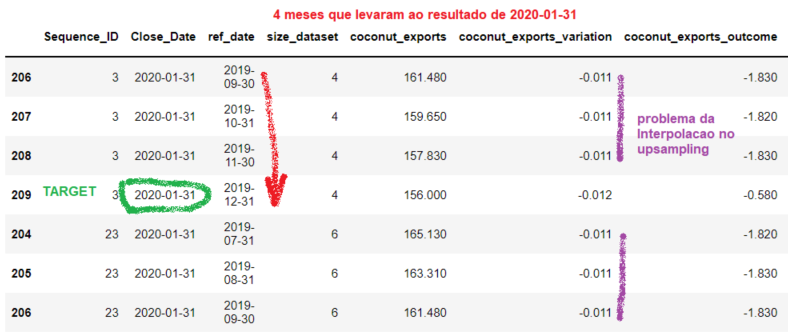

In [481]:
# pego uma data do step anterior
# observe que a saida possui
dia = df1.query(f'Close_Date == "{ref_date}"')
print(dia.shape)
dia.head()

(40, 82)


,Sequence_ID,Close_Date,ref_date,size_dataset,coconut_exports,coconut_exports_variation,coconut_exports_outcome,coconut_price,coconut_price_variation,coconut_price_outcome,...,vegetable-oil_price_outcome,vegetable-oil_production,vegetable-oil_production_variation,vegetable-oil_production_outcome,vegetable-oil_oecd_exports,vegetable-oil_oecd_exports_variation,vegetable-oil_oecd_exports_outcome,vegetable-oil_oecd_production,vegetable-oil_oecd_production_variation,vegetable-oil_oecd_production_outcome
206,3,2020-01-31,2019-09-30,4,161.480,-0.011,-1.830,724.030,0.007,-4.510,...,0.221,18564.150,0.001,23.180,7208.330,-0.002,-15.660,17669.010,0.000,4.060
207,3,2020-01-31,2019-10-31,4,159.650,-0.011,-1.820,719.520,-0.006,129.400,...,9.055,18587.330,0.001,23.230,7192.670,-0.002,-15.660,17673.070,0.000,4.060
208,3,2020-01-31,2019-11-30,4,157.830,-0.011,-1.830,848.920,0.180,182.370,...,8.335,18610.560,0.001,23.180,7177.010,-0.002,-15.660,17677.130,0.000,4.060
209,3,2020-01-31,2019-12-31,4,156.000,-0.012,-0.580,1031.290,0.215,-27.570,...,7.234,18633.740,0.001,2.030,7161.350,-0.002,11.650,17681.190,0.000,18.940
204,23,2020-01-31,2019-07-31,6,165.130,-0.011,-1.820,657.310,0.034,61.970,...,4.499,18517.750,0.001,23.210,7239.650,-0.002,-15.660,17660.890,0.000,4.060


In [482]:
# executa o quantiles
diaq = quantiles_v2(dia, size=QTD_BINS)
print(diaq.shape)
diaq.head()

(40, 112)


,Sequence_ID,Close_Date,ref_date,size_dataset,event_pattern_exports,event_pattern_prices,event_pattern_production,veg_pattern,coconut_exports,coconut_exports_outcome,...,vegetable-oil_oecd_production_variation,vegetable-oil_oecd_production_variation_qcut,vegetable-oil_price,vegetable-oil_price_outcome,vegetable-oil_price_variation,vegetable-oil_price_variation_qcut,vegetable-oil_production,vegetable-oil_production_outcome,vegetable-oil_production_variation,vegetable-oil_production_variation_qcut
206,3,2020-01-31,2019-09-30,4,BABBBBB,HHGHIGG,MNNNNNN,TTTTT,161.480,-1.830,...,0.000,T,83.888,0.221,0.016,T,18564.150,23.180,0.001,T
207,3,2020-01-31,2019-10-31,4,AAAAAAA,GGHGGGG,MMMMMMM,SSSSS,159.650,-1.820,...,0.000,S,84.109,9.055,0.003,S,18587.330,23.230,0.001,S
208,3,2020-01-31,2019-11-30,4,ABAAAAA,IIIGGHG,NMMMNMM,SUSSS,157.830,-1.830,...,0.000,S,93.164,8.335,0.108,U,18610.560,23.180,0.001,S
209,3,2020-01-31,2019-12-31,4,AAAAAAA,IIIIHIG,MMMMMMM,SUSSS,156.000,-0.580,...,0.000,S,101.499,7.234,0.089,U,18633.740,2.030,0.001,S
204,23,2020-01-31,2019-07-31,6,BBBBBBB,HHGIHHI,NNNNONN,SSTTT,165.130,-1.820,...,0.000,T,78.090,4.499,0.008,S,18517.750,23.210,0.001,T


Possibilidade de observação de transicoes de estado no campo exportacao da tabela que levaram ao estado atual.

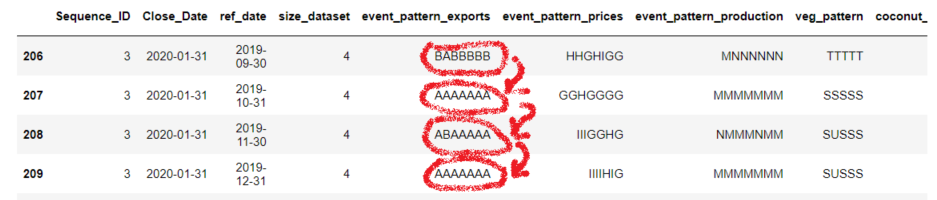

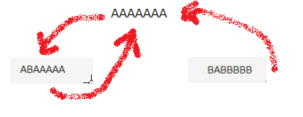

In [483]:
comp = compress_v1(diaq, columns = ['Sequence_ID', 'Close_Date'], predictors = PREDITOR,  outcomes = outcomes)#.to_markdown(tablefmt="psql")
print(comp.shape)
comp['events_pattern'].reset_index()
comp.head()
comp[PREDITOR]

(5, 31)


,,vegetable-oil_price,vegetable-oil_production,vegetable-oil_exports
Sequence_ID,Close_Date,,,
3,2020-01-31,90.665,18598.945,7859.365
23,2020-01-31,87.223,18575.748,7851.995
110,2020-01-31,89.050,18587.348,7855.680
117,2020-01-31,83.510,18517.745,7833.576
185,2020-01-31,82.307,18481.531,7819.934


In [484]:
compress_v2(diaq, columns = ['Sequence_ID', 'Close_Date'],  outcomes = outcomes)

,,events_pattern,veg_pattern,coconut_exports_outcome,coconut_price_outcome,coconut_production_outcome,palm-kernel_exports_outcome,palm-kernel_price_outcome,palm-kernel_production_outcome,palm_exports_outcome,palm_price_outcome,...,soybean_price_outcome,soybean_production_outcome,sunflower_exports_outcome,sunflower_price_outcome,sunflower_production_outcome,vegetable-oil_exports_outcome,vegetable-oil_price_outcome,vegetable-oil_production_outcome,vegetable-oil_oecd_exports_outcome,vegetable-oil_oecd_production_outcome
Sequence_ID,Close_Date,,,,,,,,,,,,,,,,,,,,,
3,2020-01-31,"AAAAAAA,BABBBBB,ABAAAAA,HHGHIGG,IIIGGHG,GGHGGG...","SSSSS,TTTTT,SUSSS",-1.515,69.923,-0.910,-0.728,89.345,-0.558,-18.705,57.443,...,24.097,15.727,6.375,7.727,4.493,1.750,6.211,17.905,-8.832,7.780
23,2020-01-31,"BABBBBB,AAAAAAA,BBBBBBB,ABAAAAA,HHGHIGG,IIIGGH...","SSSSS,SSTTT,TTTTT,SUSSS",-1.618,57.735,-0.995,-0.715,69.250,-0.515,-20.482,44.365,...,21.245,16.177,8.807,8.847,6.557,3.625,5.107,19.670,-11.108,6.540
110,2020-01-31,"BABBBBB,AAAAAAA,BBBBBBB,ABAAAAA,HHGHIGG,IIIGGH...","SSSSS,TTTTT,SUSSS",-1.578,56.888,-0.962,-0.720,70.240,-0.532,-19.770,44.790,...,16.486,15.996,7.834,6.182,5.732,2.876,5.229,18.962,-10.198,7.036
117,2020-01-31,"CCCACCC,BBBBBBB,ABAAAAA,AAAAAAA,BABBBBB,CCCCCC...","USUUS,SSTTT,USUUU,SSSSS,UTUUU,TTTTT,SUSSS",-1.713,26.663,-1.074,-0.702,25.078,-0.476,-22.096,18.827,...,9.347,16.585,11.015,9.719,8.435,5.327,2.450,21.275,-13.176,5.412
185,2020-01-31,"CCCCAAA,CCCACCC,BBBBBBB,ABAAAAA,AAAAAAA,BABBBB...","USUUS,USUUU,SSTTT,SSSSS,UTUUU,TTTTT,SUSSS",-1.424,17.461,-0.975,-0.511,18.779,-0.269,-19.268,19.355,...,10.459,16.329,11.193,7.201,8.661,8.354,2.296,23.099,-9.899,7.055


Decisao, **usar a versao1 do compress!** O Metodo markov pede a transicao de estados. E são essas transições que serao utilizadas para observar as probabilidades de decisao de transicao de estado.

## Compressing

In [485]:
df3 = compress_v1(df2, columns = ['Sequence_ID', 'Close_Date'],  outcomes = outcomes)
print(df3.shape)
df3.tail()

(197, 28)


,,events_pattern,veg_pattern,coconut_exports_outcome,coconut_price_outcome,coconut_production_outcome,palm-kernel_exports_outcome,palm-kernel_price_outcome,palm-kernel_production_outcome,palm_exports_outcome,palm_price_outcome,...,soybean_price_outcome,soybean_production_outcome,sunflower_exports_outcome,sunflower_price_outcome,sunflower_production_outcome,vegetable-oil_exports_outcome,vegetable-oil_price_outcome,vegetable-oil_production_outcome,vegetable-oil_oecd_exports_outcome,vegetable-oil_oecd_production_outcome
Sequence_ID,Close_Date,,,,,,,,,,,,,,,,,,,,,
195,2009-11-30,"CBBBBCB,CBBBBCB,CBBBBCB,CBBBBCB,CBBBBCB,CBBBBC...","TTUST,TUUST,TUUST,TSUST,TSUST,TUUST,TSUST,TTUST",4.125,13.000,0.861,0.424,21.034,2.375,9.174,12.856,...,25.209,40.056,-0.332,20.500,1.604,26.466,2.533,71.140,2.425,36.921
196,2019-08-31,"CCBBBBB,CCBBBBB,AAABBCC,AAABBCC,AAABBCC,AAABBC...","TSSTS,TTSTS,SUSSS,STSSS,SSSSS,STSSS,STSSS,STSS...",-1.338,-4.442,-0.982,-0.396,-9.810,-0.122,-18.989,5.224,...,7.110,16.514,13.059,7.768,10.288,11.398,0.666,25.398,-9.732,7.066
197,2011-01-31,"AABACBB,AABACBB,AABACBB,AAAACBB,AAAACBB,IIIIII...","SUTUU,SUTUU,SUTUU,SUTUU,SUTTU",-1.412,173.600,0.396,-0.504,193.582,1.424,9.094,71.968,...,73.622,13.628,2.900,83.600,2.958,10.586,10.536,47.644,28.780,60.082
198,2008-03-31,"CBCAAAA,ABBCCAC,ABBCCAC,HHHIIII,IIIHIII,IIIGII...","TTTUT,SUTTT,SUSTT",-3.120,106.000,-0.377,1.410,106.620,1.897,17.473,125.000,...,100.337,-16.857,7.090,131.333,11.347,1.530,12.682,30.640,18.453,33.100
199,2010-06-30,"CBBABCB,AABACBB,AABACBB,AABACBB,AABACBB,AABACB...","TUUST,TTTUU,TTTUU,TUTUU,TTTUU,TSTUU",-1.868,37.500,0.847,-0.542,35.758,1.098,6.972,0.645,...,-13.272,17.300,0.257,-16.167,-0.258,7.763,-0.256,46.963,30.148,63.377


In [486]:
df3.columns

Index(['events_pattern', 'veg_pattern', 'coconut_exports_outcome',
       'coconut_price_outcome', 'coconut_production_outcome',
       'palm-kernel_exports_outcome', 'palm-kernel_price_outcome',
       'palm-kernel_production_outcome', 'palm_exports_outcome',
       'palm_price_outcome', 'palm_production_outcome',
       'peanut_exports_outcome', 'peanut_price_outcome',
       'peanut_production_outcome', 'rapeseed_exports_outcome',
       'rapeseed_price_outcome', 'rapeseed_production_outcome',
       'soybean_exports_outcome', 'soybean_price_outcome',
       'soybean_production_outcome', 'sunflower_exports_outcome',
       'sunflower_price_outcome', 'sunflower_production_outcome',
       'vegetable-oil_exports_outcome', 'vegetable-oil_price_outcome',
       'vegetable-oil_production_outcome',
       'vegetable-oil_oecd_exports_outcome',
       'vegetable-oil_oecd_production_outcome'],
      dtype='object')

## Simplificando o Dataset


O objetivo aqui é remover variacoes de pouca relevancia.

Exemplo: 
- A flutuação de + ou - 10 centavos de dolar pode não ser representativo em um dataset de preço da tonela oleo de soja ... que opera na casa de milhares de dolares. Mas 10 centavos é representativo para o cambio dolar/real, que opera na casa  5 BRL ~ 1 USD.
- Pode ser até erro de precisão. 1000 kg ou 999 kg é a mesma coisa em termos de ordem de grandeza

In [487]:
df3[[x for x in df3.columns if 'vegetable' in x  ]].describe()

,vegetable-oil_exports_outcome,vegetable-oil_price_outcome,vegetable-oil_production_outcome,vegetable-oil_oecd_exports_outcome,vegetable-oil_oecd_production_outcome
count,197.000,197.000,197.000,197.000,197.000
mean,17.018,0.289,42.746,17.949,42.765
std,19.976,4.317,21.738,14.719,23.886
min,-28.240,-19.281,-9.230,-24.600,-17.340
25%,3.625,-1.468,30.637,11.650,31.120
50%,19.603,-0.098,46.962,19.448,42.386
75%,28.964,1.487,58.622,28.780,61.317
max,60.740,15.453,84.146,48.134,106.724


In [488]:
relevant_cut_off  = .5 #variacao maior que .5 pontos 
outcome_reference = 'vegetable-oil_price_outcome'

print(f'All available data: { df3.shape[0]}')
df4 = df3[ abs(df3[outcome_reference]) > relevant_cut_off ][:]
print(f'Relevant changes: { df4.shape[0]}')

All available data: 197
Relevant changes: 156


In [489]:
df4[[x for x in df4.columns if 'vegetable' in x]].describe()

,vegetable-oil_exports_outcome,vegetable-oil_price_outcome,vegetable-oil_production_outcome,vegetable-oil_oecd_exports_outcome,vegetable-oil_oecd_production_outcome
count,156.000,156.000,156.000,156.000,156.000
mean,16.284,0.378,40.137,17.646,40.404
std,20.153,4.848,21.527,14.712,23.125
min,-28.240,-19.281,-9.230,-24.597,-17.340
25%,3.429,-1.741,29.419,11.647,29.594
50%,17.161,0.573,43.388,18.758,37.404
75%,28.601,2.344,56.005,28.226,55.743
max,60.740,15.453,84.146,48.134,106.724


## Directions

Neste ponto, o objetivo é criar um flag 0/1 (False/True) para informar se a sequencia de transição direcionar para crescimento (bulish) ou para caida (bearish).


In [490]:
def directions(df: pd.DataFrame):
    df    = df.copy()

    for col in [x for x in df.columns if 'outcome' in x ]:
        column_name         = f'{col}_direction'
        df[column_name]     = df[col].apply(lambda x: 1 if x > 0 else 0 )

    # quantidade de colunas sem outcome na descricao
    qtd_cols = len([x for x in df.columns if 'outcome' not in x])
        
    columns_fixed   = list(df.columns[:qtd_cols])
    columns_sort    = sorted(list(df.columns[qtd_cols:]))
    
    return df[columns_fixed + columns_sort].sort_values(by = ['Sequence_ID'], ascending=[True]) \
            .reset_index().set_index(['Sequence_ID', 'Close_Date'])

    return df[columns_fixed + columns_sort].sort_values(by = ['Close_Date'], ascending=[True]) \
            .reset_index().set_index(['Sequence_ID', 'Close_Date'])

In [491]:
#sem simplificacao
%time df5 = directions(df4)
print(df5.shape)
df5.head()

CPU times: total: 15.6 ms
Wall time: 20 ms
(156, 54)


,,events_pattern,veg_pattern,coconut_exports_outcome,coconut_exports_outcome_direction,coconut_price_outcome,coconut_price_outcome_direction,coconut_production_outcome,coconut_production_outcome_direction,palm-kernel_exports_outcome,palm-kernel_exports_outcome_direction,...,vegetable-oil_exports_outcome,vegetable-oil_exports_outcome_direction,vegetable-oil_oecd_exports_outcome,vegetable-oil_oecd_exports_outcome_direction,vegetable-oil_oecd_production_outcome,vegetable-oil_oecd_production_outcome_direction,vegetable-oil_price_outcome,vegetable-oil_price_outcome_direction,vegetable-oil_production_outcome,vegetable-oil_production_outcome_direction
Sequence_ID,Close_Date,,,,,,,,,,,,,,,,,,,,,
0,2004-04-30,"BCCCCBB,BCCCCBB,BCCCCBB,BCCCCBB,CCCAACA,CCCAAC...","UUUTU,UUUTU,UTUTU,UUUTU,UTUUU,UUUUU,UTUUU",1.333,1,43.571,1,0.921,1,1.596,1,...,30.277,1,22.296,1,63.671,1,2.445,1,59.720,1
1,2011-03-31,"AABACBB,AABACBB,AABACBB,AABACBB,AABACBB,AABACB...","TTTUU,TSTUU,TTTUU,SUTUU,SUTUU,SUTUU,SUTUU,SUTU...",-1.245,0,89.545,1,0.234,1,-0.493,0,...,11.612,1,28.282,1,58.881,1,4.886,1,47.887,1
2,2006-07-31,"ACAACCB,ACAACCB,ACAACCB,ACAACCB,ACAACCB,ACAACC...","TTTSS,TTTSS,TTTSS,TUTSS,TTTSS,TTTSS",-2.175,0,2.375,1,-1.827,0,2.590,1,...,19.603,1,7.783,1,25.823,1,1.129,1,29.412,1
3,2020-01-31,"AAABBCC,AAABBCB,AAABBCB,AAABBCB,HHHHIGH,HGHHHH...","STSSS,STSSS,SUSSS,SUSSS",-1.515,0,69.923,1,-0.910,0,-0.728,0,...,1.750,1,-8.832,0,7.780,1,6.211,1,17.905,1
4,2020-08-31,"AAABBCC,AAABBCC,AAABBCB,AAABBCB,AAABBCB,BAACBB...","SUSSS,STSSS,STSSS,SUSSS,SUSSS,SUSSS,SSSSS,SSSS...",-0.993,0,21.835,1,-0.482,0,-0.798,0,...,-7.612,0,2.544,1,13.983,1,1.343,1,9.080,1


## Split Train/Test

O Shuffle esta desativado. Não sera realizado embaralhamento de serie temporal, para evitar o erro de prever o passado com dados do futuro.

In [492]:
event_patterns = [x for x in df5.columns if 'events_pattern' in x  ]

feature_directions = event_patterns + [x for x in df5.columns if 'direction' in x and 'vegetable-oil' not in x ]

predictors = [x for x in df5.columns if 'direction' in x and 'vegetable-oil' in x and 'oecd' not in x ]
predictors

['vegetable-oil_exports_outcome_direction',
 'vegetable-oil_price_outcome_direction',
 'vegetable-oil_production_outcome_direction']

In [493]:
X = df5[feature_directions]
y = df5[predictors]


In [494]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=False)
print(f'X_train: {X_train.shape} | X_test: {X_test.shape} | y_train: {y_train.shape} | y_test: {y_test.shape} ')

X_train: (148, 22) | X_test: (8, 22) | y_train: (148, 3) | y_test: (8, 3) 


In [495]:
X_train = X_train.sort_values(by=['Sequence_ID'])
X_train.sort_values(by=['Close_Date'], ascending=[False]).head()

,,events_pattern,coconut_exports_outcome_direction,coconut_price_outcome_direction,coconut_production_outcome_direction,palm-kernel_exports_outcome_direction,palm-kernel_price_outcome_direction,palm-kernel_production_outcome_direction,palm_exports_outcome_direction,palm_price_outcome_direction,palm_production_outcome_direction,...,peanut_production_outcome_direction,rapeseed_exports_outcome_direction,rapeseed_price_outcome_direction,rapeseed_production_outcome_direction,soybean_exports_outcome_direction,soybean_price_outcome_direction,soybean_production_outcome_direction,sunflower_exports_outcome_direction,sunflower_price_outcome_direction,sunflower_production_outcome_direction
Sequence_ID,Close_Date,,,,,,,,,,,,,,,,,,,,,
63,2021-11-30,"AAACBBA,AAACBBA,AAACBBA,IIIHIII,IHIHHII,IIIGHH...",0,1,0,0,1,0,0,1,1,...,1,1,1,1,1,1,1,0,1,0
50,2021-07-31,"BAACBBA,AAACBBA,AAACBBA,AAACBBA,GGIIIII,IIIHII...",0,1,0,0,1,0,0,1,1,...,1,1,1,1,1,1,1,0,1,0
28,2021-06-30,"AAACBBA,IIIGHHH,NMMNNMM",0,1,0,0,1,0,0,1,1,...,1,1,1,1,1,1,1,0,1,0
162,2021-06-30,"BAACBBA,AAACBBA,AAACBBA,AAACBBA,GGIIIII,IIIHII...",0,1,0,0,1,0,0,1,1,...,1,1,1,1,1,1,1,0,1,0
184,2021-05-31,"BAACBBA,AAACBBA,BAACBBA,AAACBBA,AAACBBA,AAACBB...",0,1,0,0,1,0,0,1,1,...,1,1,1,1,1,1,1,0,1,0


In [496]:
X_test = X_test.sort_values(by=['Sequence_ID'])
X_test.sort_values(by=['Close_Date'], ascending=[False]).head()

,,events_pattern,coconut_exports_outcome_direction,coconut_price_outcome_direction,coconut_production_outcome_direction,palm-kernel_exports_outcome_direction,palm-kernel_price_outcome_direction,palm-kernel_production_outcome_direction,palm_exports_outcome_direction,palm_price_outcome_direction,palm_production_outcome_direction,...,peanut_production_outcome_direction,rapeseed_exports_outcome_direction,rapeseed_price_outcome_direction,rapeseed_production_outcome_direction,soybean_exports_outcome_direction,soybean_price_outcome_direction,soybean_production_outcome_direction,sunflower_exports_outcome_direction,sunflower_price_outcome_direction,sunflower_production_outcome_direction
Sequence_ID,Close_Date,,,,,,,,,,,,,,,,,,,,,
196,2019-08-31,"CCBBBBB,CCBBBBB,AAABBCC,AAABBCC,AAABBCC,AAABBC...",0,0,0,0,0,0,0,1,0,...,1,1,1,1,1,1,1,1,1,1
194,2018-03-31,"BAABAAA,BAABAAA,CCBBBBB,CCBBBBB,IHGIIHH,GGGHGG...",1,0,1,1,0,1,1,0,1,...,1,1,0,0,1,0,1,1,0,1
190,2013-10-31,"BAACABC,BAACABC,BAACABC,BAACABC,BAACABC,IHHHHG...",0,1,0,0,1,1,1,0,1,...,1,0,0,1,0,0,1,1,0,1
193,2012-01-31,"CABBCAC,CABBCAC,CABBCAC,BABBCAC,CABBCAC,CABBCA...",1,0,0,1,0,1,1,0,1,...,1,1,0,1,0,0,1,1,0,1
197,2011-01-31,"AABACBB,AABACBB,AABACBB,AAAACBB,AAAACBB,IIIIII...",0,1,1,0,1,1,1,1,1,...,1,1,1,1,0,1,1,1,1,1


In [497]:
[x for x in df5.columns if 'direction' in x ]

['coconut_exports_outcome_direction',
 'coconut_price_outcome_direction',
 'coconut_production_outcome_direction',
 'palm-kernel_exports_outcome_direction',
 'palm-kernel_price_outcome_direction',
 'palm-kernel_production_outcome_direction',
 'palm_exports_outcome_direction',
 'palm_price_outcome_direction',
 'palm_production_outcome_direction',
 'peanut_exports_outcome_direction',
 'peanut_price_outcome_direction',
 'peanut_production_outcome_direction',
 'rapeseed_exports_outcome_direction',
 'rapeseed_price_outcome_direction',
 'rapeseed_production_outcome_direction',
 'soybean_exports_outcome_direction',
 'soybean_price_outcome_direction',
 'soybean_production_outcome_direction',
 'sunflower_exports_outcome_direction',
 'sunflower_price_outcome_direction',
 'sunflower_production_outcome_direction',
 'vegetable-oil_exports_outcome_direction',
 'vegetable-oil_oecd_exports_outcome_direction',
 'vegetable-oil_oecd_production_outcome_direction',
 'vegetable-oil_price_outcome_direction',

In [498]:
print(X_train.shape, "Metade de linhas:", X_train.shape[0]/2)
print('=='*60)
print('Vou usar a referencia de "sunflower_production_outcome_direction" por ser o fator determinando pertubador de mercado. ')
print('=='*60)

X_train[[x for x in X_train.columns if 'direction' in x ]].sum()

(148, 22) Metade de linhas: 74.0
Vou usar a referencia de "sunflower_production_outcome_direction" por ser o fator determinando pertubador de mercado. 


coconut_exports_outcome_direction            67
coconut_price_outcome_direction              77
coconut_production_outcome_direction         74
palm-kernel_exports_outcome_direction       104
palm-kernel_price_outcome_direction          70
palm-kernel_production_outcome_direction    117
palm_exports_outcome_direction              113
palm_price_outcome_direction                 72
palm_production_outcome_direction           129
peanut_exports_outcome_direction             94
peanut_price_outcome_direction               92
peanut_production_outcome_direction          86
rapeseed_exports_outcome_direction          134
rapeseed_price_outcome_direction             82
rapeseed_production_outcome_direction       132
soybean_exports_outcome_direction            90
soybean_price_outcome_direction              79
soybean_production_outcome_direction        127
sunflower_exports_outcome_direction         103
sunflower_price_outcome_direction            78
sunflower_production_outcome_direction  

## Bullish/Bearish Cenario

In [499]:
direction_reference = 'sunflower_production_outcome_direction'
df6_pos = X_train.loc[X_train[direction_reference] > 0]
df6_neg = X_train.loc[X_train[direction_reference] <= 0]
print(f'df6_pos: {df6_pos.shape} | df6_neg: {df6_neg.shape}')

df6_pos: (106, 22) | df6_neg: (42, 22)


## Unique Patterns

In [500]:
def get_unique_patterns_V2(input_array: np.ndarray, **kwargs):
    """ 
    Aqui o 'get_labels' nao deve fazer parte... pois os unique patterns pode estar agrupado. Ex. AAA, ABC, etc
    """
    unique_patterns = []
    for i in range(len(input_array[0])):

        flat_list = [ item[i].split(',') for item in input_array ]
        temp_patterns = ','.join(str(r) for v in flat_list for r in v)
        unique_patterns += temp_patterns.split(',')
                
    unique_patterns = sorted(list( set(unique_patterns ) ))
    return unique_patterns

In [505]:
## X_train[event_patterns].values[1][0].split(",")[0].split('-')

In [510]:
# flat_list = [ item[0].split(',') for item in X_train[event_patterns].values ]
# flat_list = [ j[0].split('-') for j in   [i[0].split(",") for i in X_train[event_patterns].values]] 
# flat_list
# # unique_patterns = ','.join(str(r) for v in flat_list for r in v)
# # unique_patterns = sorted(list( set( unique_patterns.split(',') ) ))
# unique_patterns

In [512]:
unique_patterns = get_unique_patterns_V2(X_train[event_patterns].values)
print(len(unique_patterns), unique_patterns[194:])

224 ['MNNONNO', 'MNNONOO', 'MNNOOOO', 'MNONOMO', 'MONNNMO', 'NMMMMOM', 'NMMMNOM', 'NMMNMNN', 'NMMNNMM', 'NMNMNOM', 'NNNMMNN', 'NNNMNOM', 'NNNMOMO', 'NNNNMNN', 'NNONOMO', 'NOOMMOO', 'NOOOMNO', 'NOOOOMO', 'OMNOMNM', 'ONMMOON', 'OONNNMM', 'OONNNNM', 'OOOMOOM', 'OOONNMM', 'OOONNMN', 'OOONNNM', 'OOOONMM', 'OOOONMN', 'OOOOOMM', 'OOOOOMO']


## Matriz de Markov

Matriz estocastica
- cada elemento da matriz é positivo
- a somatoria de cada linha é 1

In [594]:

def build_transition_grid_v2(df: pd.DataFrame, unique_patterns):
    '''
    build the markov transition grid
    '''
    patterns  = []
    counts    = []
    counts_fk = {}
    
    #unique_patterns = unique_patterns[:3]
    event_patterns  = [x for x in df.columns if 'events_pattern' in x  ]

    stop = 0
    
    # de
    for from_event in unique_patterns:
        
        # para
        for to_event in unique_patterns:
            
            pattern_to_search = from_event + ',' + to_event # MMM,MlM
            pattern_to_search_inv = to_event + ',' + from_event
            
            #Insere o valor ja capturado anteriormente
            if pattern_to_search_inv in patterns:
                patterns.append(pattern_to_search)
                counts.append(counts_fk[pattern_to_search_inv] )                
                continue
            
            
            for col in event_patterns:    
                
                if from_event == to_event:
                    ids_matches = df[( df[col].str.contains(from_event) ) |
                                     ( df[col].str.contains(to_event  ) ) ]  

                    found = len(ids_matches) if len(ids_matches) > 0 else 1
                    found = found
                else:
                    ids_matches = df[( df[col].str.contains(from_event) ) &
                                     ( df[col].str.contains(to_event  ) ) ]
                    
                    found = len(ids_matches)                
                
                # if len(ids_matches) > 0:
                #     Event_Pattern = '---'.join(ids_matches[col].values)
                #     found = ( Event_Pattern.count(from_event) + Event_Pattern.count(to_event) )

                log.debug(f'{col}==> {from_event} & {to_event} | ids_matches: {len(ids_matches)} | found: {found} ')
                patterns.append(pattern_to_search)
                # patterns.append(pattern_to_search_inv)
                counts.append(found)

                counts_fk[pattern_to_search]        = found #f'{len(ids_matches)}|{found}'
                counts_fk[pattern_to_search_inv]    = found #f'{len(ids_matches)}|{found}'
                found=found
                
        stop +=1
        if stop>5:
            break
            None
            

def build_transition_grid_v1(df: pd.DataFrame, unique_patterns):
    '''
    build the markov transition grid
    '''
    patterns  = []
    counts    = []
    counts_fk = {}
    stop      = 0
    
    event_patterns  = [x for x in df.columns if 'events_pattern' in x  ]

    #para cada pattern
    for col in event_patterns:

        # de
        for from_event in unique_patterns:
            
            # para
            for to_event in unique_patterns:
                pattern = f'{from_event},{to_event}' # MMM,MlM

                # captura a transicao de um estado para outro
                ids_matches = df[df[col].str.contains(pattern)]
                #print(ids_matches)

                found = 0
                if len(ids_matches) > 0:
                    Event_Pattern = '---'.join(ids_matches[col].values)
                    found = Event_Pattern.count(pattern)
                    log.debug(f'pattern => {pattern} | ids_matches: {len(ids_matches)} | found: {found} | {stop}')
                    
                patterns.append(pattern)
                counts.append(found)

                counts_fk[pattern] = f'{len(ids_matches)}|{found}'

            
#             stop +=1
#             if stop>5:
#                 break
#                 None
#     logging.basicConfig(level=logging.DEBUG)    
    return build_grid_markov(patterns, counts, counts_fk)
    

reset_logging()
    
# # logging.basicConfig(level=logging.DEBUG)
# x = build_transition_grid_v1(df6_neg, unique_patterns[194:])
# x
# # x.T.sum()

In [598]:
def build_grid_markov(patterns, counts, counts_fk):

#     log.debug(f'patterns: {patterns}')
#     log.debug(f'counts: {counts}')
#     log.debug(f'counts_fk: {counts_fk}')

    # create to/from grid
    grid_markov = pd.DataFrame({'pairs':patterns, 'counts': counts})
    log.debug(f'CRIACAO GRID: {grid_markov.shape} | {grid_markov}')
    
    # group by, para remover as duplicacoes de multiplos patterns
    grid_markov = grid_markov.groupby(['pairs'])['counts'].sum().to_frame().reset_index()
    log.debug(f'GRID GROUPED: {grid_markov.shape} | {grid_markov}')

    # quebra em x,y a coluna combinada
    grid_markov[['x', 'y']] = grid_markov['pairs'].str.split(',', n=1, expand=True)
    log.debug(f'GRID X,Y: {grid_markov.shape} | {grid_markov}')

    # pivoteamento em x e y
    grid_markov = grid_markov.pivot(index='x', columns='y', values='counts')
    log.debug(f'GRID PIVOT: {grid_markov.shape} | {grid_markov}')
    
    # Renomeia as colunas. Remove a referencia 'y'
    grid_markov.columns= [col for col in grid_markov.columns]
    log.debug(f'GRID RENAME COLUMNS: {grid_markov}')
       
    # replace all NaN with zeros
    grid_markov.fillna(0, inplace=True)
    log.debug(f'GRID FILLNA: {grid_markov}')
    
    # cria uma coluna temporaria para a soma da linha
    grid_markov['soma'] = grid_markov.sum(axis=1)
    log.debug(f'GRID SOMA: {grid_markov.shape} | {grid_markov}')

    # grid_markov.rowSums(transition_dataframe) 
    # grid_markov = grid_markov / grid_markov['soma']
    
    # calcula o percentual de cada valor sobre a soma    
    for col in grid_markov.columns:
        grid_markov[col] = grid_markov[col] / grid_markov['soma'] 
        grid_markov.fillna(0, inplace=True)
    log.debug(f'GRID PERCENT: {grid_markov.shape} | {grid_markov}')
    
    ## Correcao onde soma eh zero
    # for i, row in grid_markov[grid_markov['soma'] == 0].iterowss

    
        
    # Para o caso da divisao por soma zero. Sera criado um proporcional 1/total de colunas.
    # Assim garantindo que a soma da linha da 1.
    # O Total de colunas tem que ser respectivo de onde correu a combinacao. Ex. event_pattern_prices
#     grid_markov.fillna(1/(grid_markov.shape[1] - 1), inplace=True)
#     log.debug(f'GRID FILLNA :{grid_markov}')
#     for idx in x[x[x.columns[0]].isna()].index:
#         print(idx)
    
    #Remove a coluna Soma    
    del grid_markov['soma']
    
    log.debug(f'Prova dos Nove - Somatorio deve ser 1 | {grid_markov.T.sum()}')

    return grid_markov

In [599]:
# logging.basicConfig(level=logging.DEBUG) 

%time grid_pos = build_transition_grid_v1(df6_pos, unique_patterns) 
grid_pos.to_excel('grid_case2_pos.xlsx')
grid_pos

CPU times: total: 23 s
Wall time: 23 s


,AAAAAAB,AAAACBB,AAABBCB,AAABBCC,AAACBBA,AABACBB,ABBCCAC,ABCAACC,ACAACCB,ACCAACC,...,OONNNMM,OONNNNM,OOOMOOM,OOONNMM,OOONNMN,OOONNNM,OOOONMM,OOOONMN,OOOOOMM,OOOOOMO
x,,,,,,,,,,,,,,,,,,,,,
AAAAAAB,0.745,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
AAAACBB,0.000,0.500,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
AAABBCB,0.000,0.000,0.462,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
AAABBCC,0.000,0.000,0.219,0.656,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
AAACBBA,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OOONNNM,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.200,0.000,0.000,0.000,0.800,0.000,0.000,0.000,0.000
OOOONMM,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.550,0.000,0.000,0.000
OOOONMN,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.278,0.000,0.000,0.722,0.000,0.000


In [600]:
%time grid_neg = build_transition_grid_v1(df6_neg, unique_patterns)
grid_neg.to_excel('grid_case2_neg.xlsx')
grid_neg

CPU times: total: 20.7 s
Wall time: 20.7 s


,AAAAAAB,AAAACBB,AAABBCB,AAABBCC,AAACBBA,AABACBB,ABBCCAC,ABCAACC,ACAACCB,ACCAACC,...,OONNNMM,OONNNNM,OOOMOOM,OOONNMM,OOONNMN,OOONNNM,OOOONMM,OOOONMN,OOOOOMM,OOOOOMO
x,,,,,,,,,,,,,,,,,,,,,
AAAAAAB,0.643,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
AAAACBB,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
AAABBCB,0.000,0.000,0.500,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
AAABBCC,0.000,0.000,0.667,0.333,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
AAACBBA,0.000,0.000,0.000,0.000,0.323,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OOONNNM,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.133,0.000,0.000,0.000,0.867,0.000,0.000,0.000,0.000
OOOONMM,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.920,0.000,0.000,0.000
OOOONMN,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [57]:
grid_pos.to_csv('../dataset/__markov_positive.csv')
grid_neg.to_csv('../dataset/__markov_negative.csv')

In [58]:
grid_pos

,DDDDDEE,DDDDDFE,DDDEDEE,DDDFDEE,DEDFEEF,DEEDFDF,DEEEEDF,DEEEFDF,DEEEFFF,DEEFEEF,...,RRRPRRP,RRRPRRQ,RRRPRRR,RRRQQRQ,RRRQRRR,RRRRQQQ,RRRRQQR,RRRRQRR,RRRRRRQ,RRRRRRR
x,,,,,,,,,,,,,,,,,,,,,
DDDDDEE,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
DDDDDFE,0.000,0.333,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.035,0.000,0.000,0.000,0.000,0.000,0.000,0.000
DDDEDEE,0.000,0.000,0.333,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
DDDFDEE,0.000,0.000,0.000,0.333,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
DEDFEEF,0.000,0.000,0.000,0.000,0.333,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RRRRQQQ,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000
RRRRQQR,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.333,0.000,0.000,0.000
RRRRQRR,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.333,0.000,0.000


# Matriz Transição
 Markov State Transition model

- https://networks.quantecon.org/ch_mcs.html
- https://python-advanced.quantecon.org/stationary_densities.html
- https://python.quantecon.org/finite_markov.html
- https://python.quantecon.org/markov_perf.html
- https://www.viralml.com/video-content.html?fm=yt&v=sdp49vTanSk
- https://pkghosh.wordpress.com/2015/07/06/customer-conversion-prediction-with-markov-chain-classifier/

$logOdds = Σlog( tp(i,j) \div tn(i,j) )$

onde
- tp(i,j) = probabilidade de transição para transição do estado i para j para valor de classe positivo (T)
- tn(i,j) = transição probabilidade de transição do estado i para j para valor de classe negativo (F)

In [ ]:
def safe_log(numerator, denominator):

    if numerator <= 0 and denominator <= 0:
        log_value = 0
    elif denominator <= 0:
        log_value = np.log(numerator / 0.00001)
    elif numerator <= 0:
        log_value = np.log(0.00001 / denominator)
    else:
        log_value = np.log(numerator / denominator)
        
    return log_value

In [ ]:
def predict_something(df_validation: pd.DataFrame, 
                      df_positive: pd.DataFrame, 
                      df_negative: pd.DataFrame):
    
    actual = []
    predicted = []
    
    list_positive = list(df_positive)
    list_negative = list(df_negative)
    total_size = len(df_validation)
    
    for row_num, seq_id in enumerate(df_validation['Sequence_ID'].values):
        patterns = df_validation[df_validation['Sequence_ID'] == seq_id]['events_pattern'].values[0].split(',')
        
        log.debug(f'patterns: {len(patterns)} | {patterns}' )
        
        pos = []
        neg = []
        log_odds = []

        for id in range(0, len(patterns) - 1):
            
#             log.debug(f'compare 1: {patterns[id]} in { list_positive}')
#             log.debug(f'compare 2: {patterns[id+1]} in { list_positive}')
#             log.debug(f'compare 3: {patterns[id]} in { list_negative}')
#             log.debug(f'compare 4: {patterns[id+1]} in { list_negative}')


            # get log odds
            # logOdds = log(tp(i,j) / tn(i,j)
            
            if patterns[id] in list_positive and patterns[id+1] in list_positive and \
                patterns[id] in list_negative and patterns[id+1] in list_negative:

                numerator = df_positive[patterns[id]][patterns[id+1]]
                denominator = df_negative[patterns[id]][patterns[id+1]]
                
                log_value = safe_log(numerator, denominator)
                
#                 log.debug(f'numerator: {numerator:.5f} | denominator: {denominator:.5f} | log_value : {log_value:.5f}')

            else:
                log_value = 0

            log_odds.append(log_value)
            pos.append(numerator)
            neg.append(denominator)
            
#             break

        summarized_log = sum(log_odds)
    
#         log.debug(f'log_value:{sum(log_odds)}')
#         log.debug(f'numerator:{sum(pos)}')
#         log.debug(f'denominator:{sum(neg)}')
            
        print('===' * 30)
        outcome = df_validation[df_validation["Sequence_ID"]==seq_id]["vegetable-oil_price_outcome_direction"].values[0]
        
        model_prediction = 1 if summarized_log > 0 else -1
        
        print(f'row_num: {row_num+1} | seq_id: {seq_id} | Processed : {((row_num+1)/total_size)*100:.2f}%')
        print(f'sum(pos): {sum(pos)} | sum(neg): {sum(neg)} | sum(pos)/sum(neg) : {sum(pos)/sum(neg)} ')
        print(f'sum(log_odds): {summarized_log}')
        
        print(f'Outcome: {outcome} | Predict: {model_prediction}')
        if model_prediction == outcome:
            print('Model Result vs. Actual is **CORRECT**')
        else: 
            print('Model Result vs. Actual is **INCORRECT**')

        actual.append(outcome)
        predicted.append(model_prediction)
        
#         break
        
    return actual, predicted

logging.basicConfig(level=logging.DEBUG)

actual, predicted = predict_something(X_test.reset_index(), grid_pos, grid_neg)

In [ ]:
list(X_test.reset_index().columns)

## AA

In [ ]:
P = [[0.9, 0.1, 0.0],
     [0.4, 0.4, 0.2],
     [0.1, 0.1, 0.8]]
mc = qe.MarkovChain(P, ('poor', 'middle', 'rich'))
mc.is_irreducible

In [ ]:
mc.period

In [ ]:
mc = qe.MarkovChain(P)
mc.stationary_distributions 

In [ ]:
neg_array = grid_neg.to_numpy()
pos_array = grid_pos.to_numpy()

pos_array

In [ ]:
mc = qe.MarkovChain(pos_array)
mc.stationary_distributions 

In [ ]:
mc.is_irreducible 

In [ ]:
mc.period

In [ ]:
pos_array[1]

In [ ]:
P = np.array(pos_array)

ψ = pos_array[1] #(0.0, 0.2, 0.8)        # Initial condition

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.set(xlim=(0, 1), ylim=(0, 1), zlim=(0, 1),
       xticks=(0.25, 0.5, 0.75),
       yticks=(0.25, 0.5, 0.75),
       zticks=(0.25, 0.5, 0.75))

x_vals, y_vals, z_vals = [], [], []
for t in range(20):
    x_vals.append(ψ[0])
    y_vals.append(ψ[1])
    z_vals.append(ψ[2])
    ψ = ψ @ P

ax.scatter(x_vals, y_vals, z_vals, c='r', s=60)
ax.view_init(30, 210)

mc = qe.MarkovChain(P)
ψ_star = mc.stationary_distributions[0]
ax.scatter(ψ_star[0], ψ_star[1], ψ_star[2], c='k', s=60)

plt.show()